In [1]:
from collections import namedtuple
from typing import Tuple

import checker
import matplotlib.pyplot as plt
import numpy as np
import utils
from sklearn import datasets

plt.rcParams["figure.figsize"] = (9, 5)

# Regresja Liniowa

Wprowadźmy sobie teraz pewien podział metod uczenia maszynowego:
1. Jak dotąd nasz zbiór treningowy składał się po prostu z listy przykładów: $X = (x_1, \ldots, x_n)$, gdzie $x_i \in \mathbb{R}^D$. Tę sytuację możemy nazwać **uczeniem nienadzorowanym** (unsupervised learning) i zazwyczaj chcemy wtedy znaleźć ciekawe właściwości naszego zbioru danych.


2. Teraz nasz zbiór będzie składał się z par: przykład $x_i$ oraz jego etykieta $y_i$, tzn.: $X = ((x_1, y_1), \ldots (x_n, y_n))$, gdzie $x_i \in \mathbb{R}^D$ natomiast $y_i \in \mathbb{R}^K$. Tę sytuację nazywamy **uczeniem nadzorowanym** i chcemy tutaj zazwyczaj znaleźć jakąś funkcję $f(x) = y$, która dla niewidzianego jeszcze przykładu $\bar{x}$ jest w stanie nam zwrócić sensowną etykietę $y$. 
    
    Dla przykładu możemy wyobrazić sobie, że każdy przykład $x$ z naszego datasetu opisuje atrybuty pewnego domu - liczbę pokoi, metraż, rok budowy, odległość w metrach od centrum miasta itd. - a etykiety $y$ reprezentują ceny tego domu. My chcielibyśmy zbudować model, który na podstawie atrybutów $x$ nowego domu, będzie w stanie dać rozsądną predykcję na temat jego ceny.


Dla uproszczenia dzisiaj przyjmiemy, że $K=1$, tzn. że nasze etykiety $y$ są jednowymiarowe. Natomiast wszystkie omawiane metody można łatwo przenieść do sytuacji wyżej wymiarowych.

### Przygotujmy sobie na początek parę datasetów i je zwizualizujmy:
Przyjmujemy, że nasz dataset jest rozmiarów `[N, D]` (na ten moment `D = 1`) natomiast etykiety to wektory o długości `N`. Stwórzmy sobie kilka "zabawkowych" datasetów.

In [7]:
np.random.seed(54)


def linear_func(X: np.ndarray) -> np.ndarray:
    return -2.5 * X


def affine_func(X: np.ndarray) -> np.ndarray:
    return -2.5 * X + 2


def square_func(X: np.ndarray) -> np.ndarray:
    return -2 * X**2 + 1 * X + 1


linear_dataset = utils.create_regression_dataset(linear_func)
affine_dataset = utils.create_regression_dataset(affine_func)
square_dataset = utils.create_regression_dataset(square_func)
bigger_square_dataset = utils.create_regression_dataset(square_func, sample_size=100)

Każdy z naszych datasetów zawiera atrybut .data z danymi X oraz .target z etykietami Y
linear_dataset.data: [[-0.39908516]
 [-0.68380252]
 [-1.57561656]
 [ 0.09141364]
 [-2.45697274]
 [ 2.34468103]
 [ 1.50690628]
 [ 1.28655994]
 [ 0.85742151]
 [-2.35171496]]
linear_dataset.target: [ 0.7035172   1.37442238  4.05564692 -0.36402631  6.27794289 -5.82459669
 -3.9986326  -3.38031002 -2.32424686  5.77345025]
Wszystkie datasety mają jednowymiarowe przykłady: (10, 1)


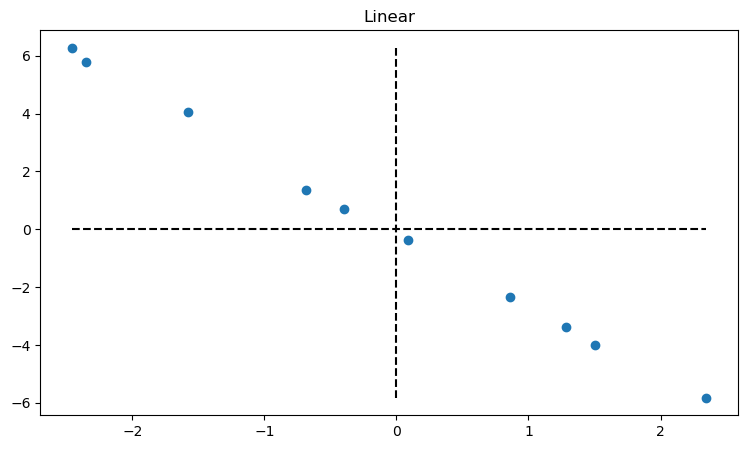

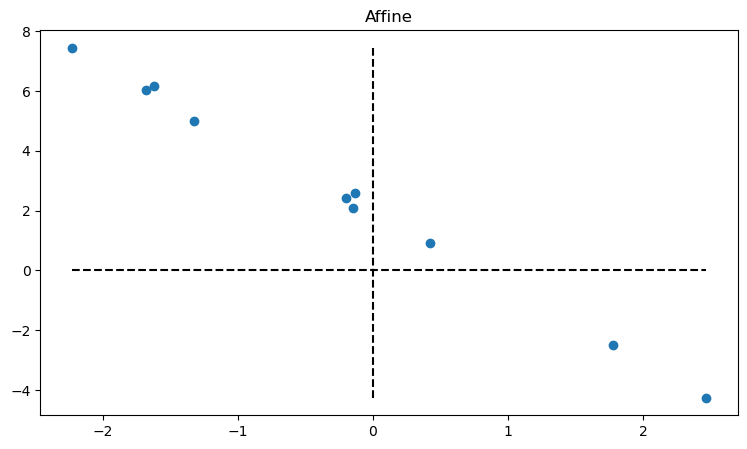

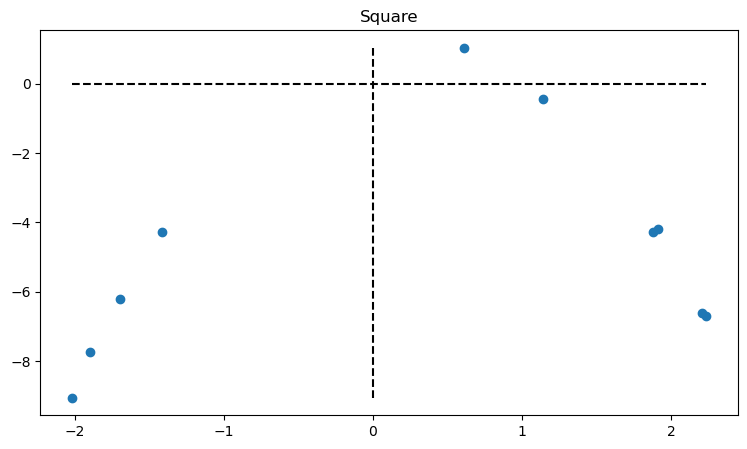

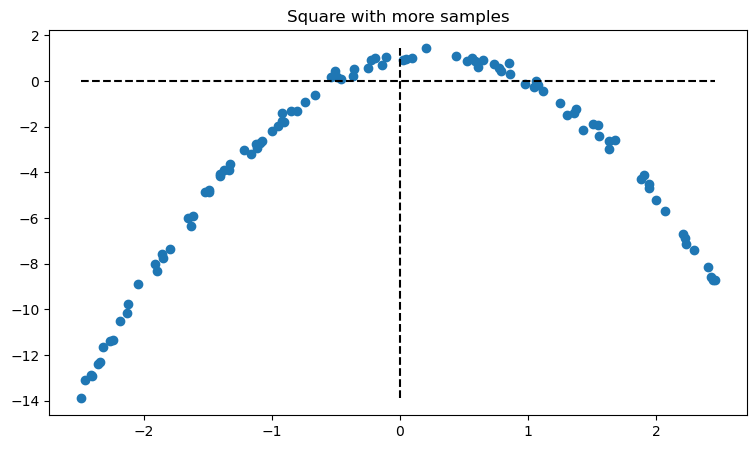

In [9]:
print("Każdy z naszych datasetów zawiera atrybut .data z danymi X oraz .target z etykietami Y")
print(f"linear_dataset.data: {linear_dataset.data}\nlinear_dataset.target: {linear_dataset.target}")
print(f"Wszystkie datasety mają jednowymiarowe przykłady: {linear_dataset.data.shape}")

utils.plot_regression_dataset(linear_dataset, "Linear")
utils.plot_regression_dataset(affine_dataset, "Affine")
utils.plot_regression_dataset(square_dataset, "Square")
utils.plot_regression_dataset(bigger_square_dataset, "Square with more samples")

## Zadanie 1 (3 pkt.)
## Regresja liniowa

Przyjmijmy, że nasza funkcja, która na podstawie $x \in \mathbb{R}^{D}$ ma nam dać jego etykietę $y$ wygląda tak:
$$ f(x) = w^T x, $$
gdzie $w$ to wektor o długości $D$.

$w$ to parametry naszego modelu - w kontekście regresji liniowej (a potem sieci neuronowych) nazywa się je też wagami.

Próbujemy znaleźć takie parametry $w$, które zminimalizują następującą funkcję mean squared error liczoną pomiędzy predykcjami naszego modelu a prawdziwymi etykietami $y \in \mathbb{R}^{N}$ z datasetu $X \in \mathbb{R}^{N x D}$:
$$
L(X, y, w) = \frac{1}{N} \sum_{i=1}^N ( f(x_i) - y_i )^2 = \frac{1}{N} \sum_{i=1}^N (w^Tx_i - y_i)^2
$$

Okazuje się, że jest na to jawny wzór (szczegóły w wykładzie):
$$ w = (X^T X)^{-1} X^T y $$


W zadaniu należy zaimplementować ponownie metodę sklearn:

1. W metodzie `fit` należy obliczyć wektor wag rozwiązujących problem regresji dla podanej macierzy `X` o wymiarach `[N, D]` oraz dla podanego wektora etykiet `y`. Należy skorzystać z powyższego jawnego wzoru.
2. Metoda `predict` ma zwracać dla podanej macierzy numpy `X` o wymiarach `[N, D]` wektor predykcji o wymiarze `[N]`.
3. W metodzie `loss` należy zaimplementować liczenie kosztu $L(X, y, w)$. Należy zwrócić skalar.


**UWAGA: self.weight ma być wektorem jednowymiarowym. Nie może być macierzą ani skalarem.**

In [11]:
class LinearRegression:
    def __init__(self) -> None:
        self.weight = None  #(np.ndarray)
 
    def fit(self, X: np.ndarray, y: np.ndarray) -> None:
        # w = (X^T X)^(-1) X^T y
        
        # X^T X
        xTx = X.T @ X
        # (X^T X)^(-1)
        inv_xTx = np.linalg.inv(xTx)
        # (X^T X)^(-1) X^T
        inv_xTx_xT = inv_xTx @ X.T

        w = inv_xTx_xT @ y
        
        self.weight = w  # w(shape (D,))

    def predict(self, X: np.ndarray) -> np.ndarray:
        # : y_pred = X @ w
        return X @ self.weight

    def loss(self, X: np.ndarray, y: np.ndarray) -> float:
        # MSE = mean(предсказание - истинное значение)^2
        y_pred = self.predict(X)
        return np.mean((y_pred - y)**2)


In [13]:
# `scikit-learn` musi być w wersji 0.23.2 aby testy działały poprawnie
checker.check_02_linear_regression(LinearRegression)

Dataset Linear
Wartość funkcji kosztu: 0.036210463807280754


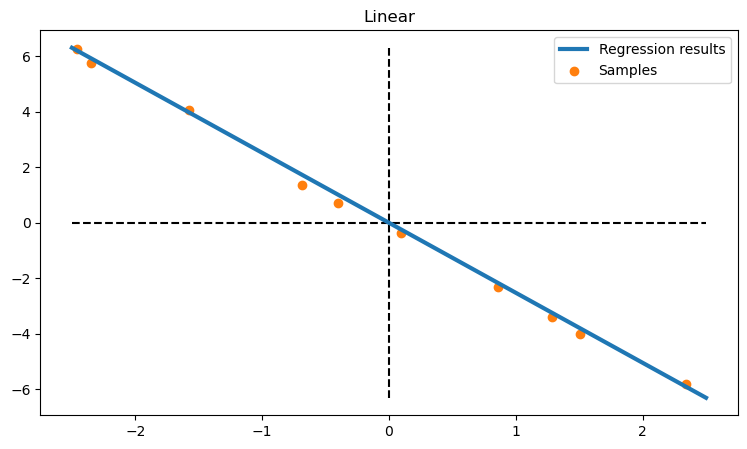

Dataset Affine
Wartość funkcji kosztu: 3.6278665190688377


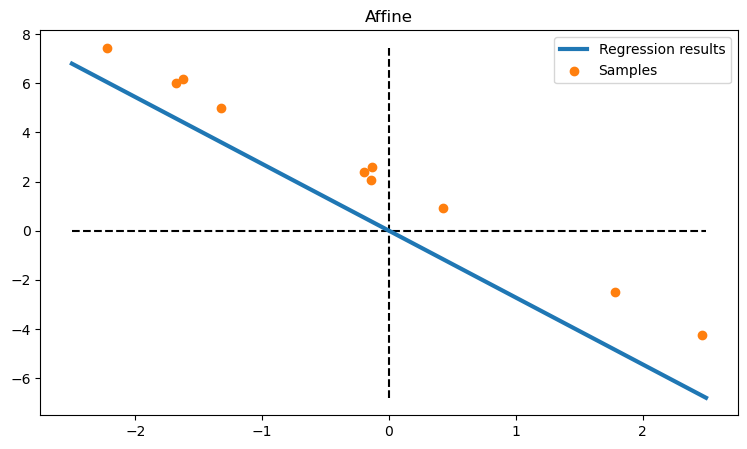

Dataset Square
Wartość funkcji kosztu: 32.39350838255639


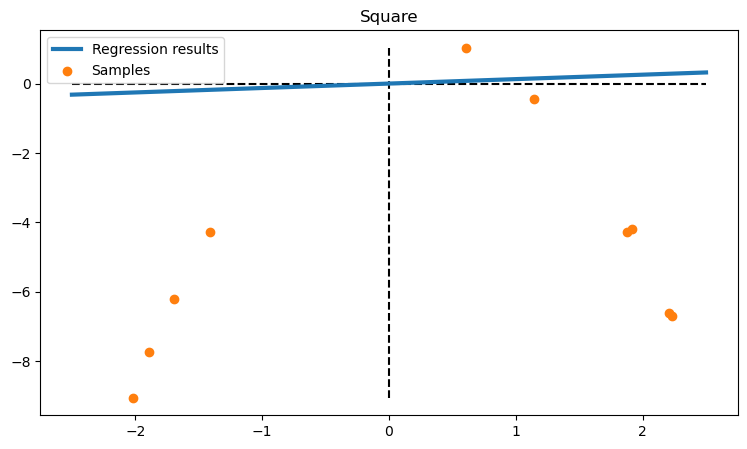

In [15]:
utils.plot_regression_results(linear_dataset, LinearRegression, "Linear")
utils.plot_regression_results(affine_dataset, LinearRegression, "Affine")
utils.plot_regression_results(square_dataset, LinearRegression, "Square")

## Zanurzenia (embedding) i funkcje bazowe

W aktualnej wersji regresja liniowa potrafi modelować tylko funkcje liniowe, które przechodzą przez środek osi układu współrzędnych. Chcielibyśmy, żeby regresja potrafiła modelować również inne funkcje. Konkretniej:

1. Funkcje afiniczne, tzn. $f(x) = w_1x + w_0$
2. Współczynniki w funkcjach wielomianowych, tzn. $f(x) = w_0 + w_1 x + w_2 x^2 + \ldots + w_n x^n$
3. Funkcje zbudowane z funkcji trygonometrycznych, tzn. $f(x) = w_0 + w_1 x + w_2 \sin(x) + w_3 \cos(x)$

Żeby to osiągnąć możemy przetransformować (zanurzyć) nasze dane:
1. $ \tilde{x_i} = [1, x_i] $
2. $ \tilde{x_i} = [1, x_i, x_i ^ 2, ... x_i ^ n] $
3. $ \tilde{x_i} = [1, x_i, \sin(x), \cos(x)] $

Po zanurzeniu możemy wykonać naszą regresję liniową na zbiorze $\tilde{X} = ((\tilde{x}_1, y_1), \ldots, (\tilde{x}_n, y_n))$. Oznacza to, że przygotowujemy ręcznie naszemu modelowi reprezentację naszego datasetu, którą da się rozwiązać liniowo. Sieci neuronowe, którymi zajmiemy się już niedługo, będą potrafiły taką reprezentację otrzymać samodzielnie.

In [17]:
def embed_bias(X: np.ndarray) -> np.ndarray:
    return np.concatenate([X, np.ones_like(X)], -1)


def embed_poly(X: np.ndarray, poly_degree: int = 2) -> np.ndarray:
    polys = [X**degree for degree in range(poly_degree + 1)]
    return np.concatenate(polys, axis=-1)


def embed_trig(X: np.ndarray) -> np.ndarray:
    trig_list = [np.ones_like(X), X, np.sin(X), np.cos(X)]
    return np.concatenate(trig_list, -1)

Dataset Affine (bias embedding)
Wartość funkcji kosztu: 0.028126132148994072


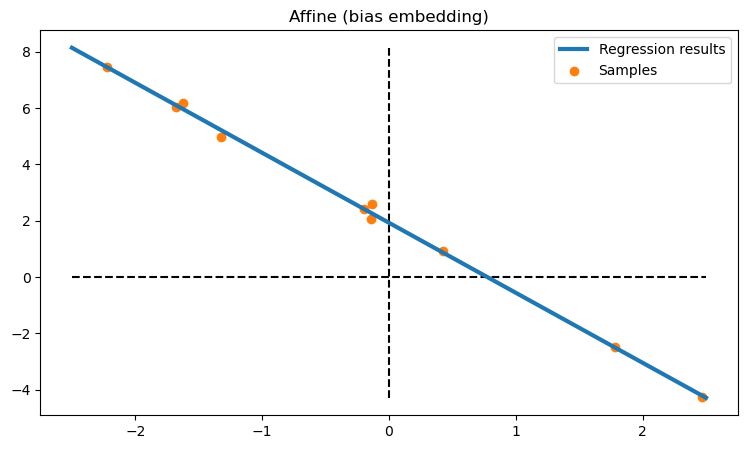

Dataset Square (bias embedding)
Wartość funkcji kosztu: 0.009882139636270878


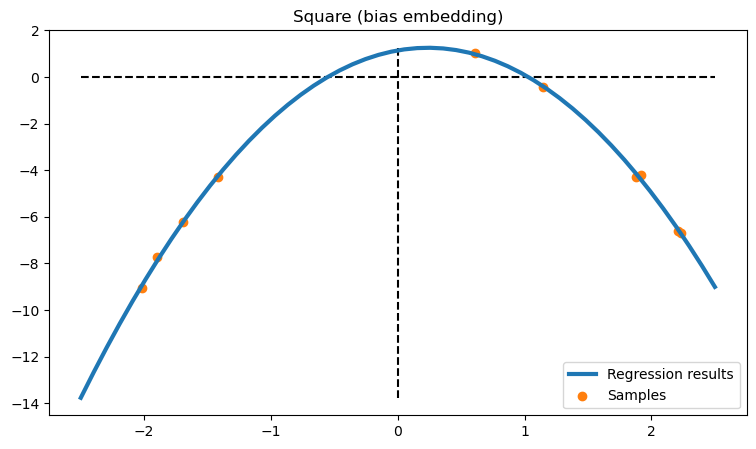

Dataset Square (trig embedding)
Wartość funkcji kosztu: 0.12480462554195593


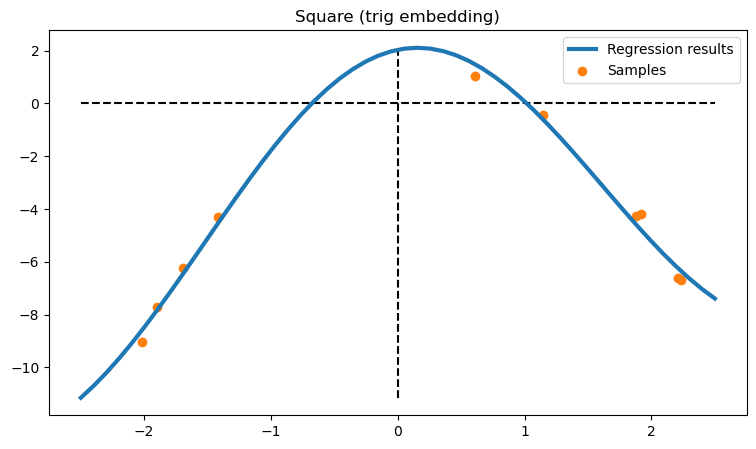

In [19]:
utils.plot_regression_results(
    affine_dataset, LinearRegression, "Affine (bias embedding)", embed_bias
)
utils.plot_regression_results(
    square_dataset, LinearRegression, "Square (bias embedding)", embed_poly
)
utils.plot_regression_results(
    square_dataset, LinearRegression, "Square (trig embedding)", embed_trig
)

## Underfitting i overfitting

Dataset Square (poly embedding, degree=1)
Wartość funkcji kosztu: 7.8235459295487955


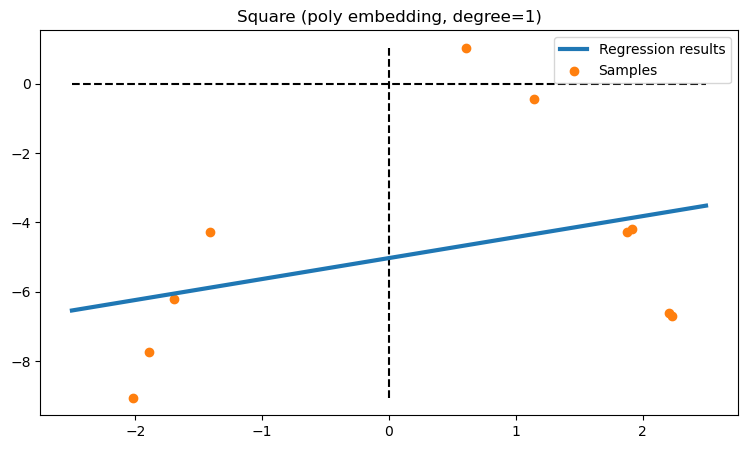

Dataset Square (poly embedding, degree=2)
Wartość funkcji kosztu: 0.009882139636270878


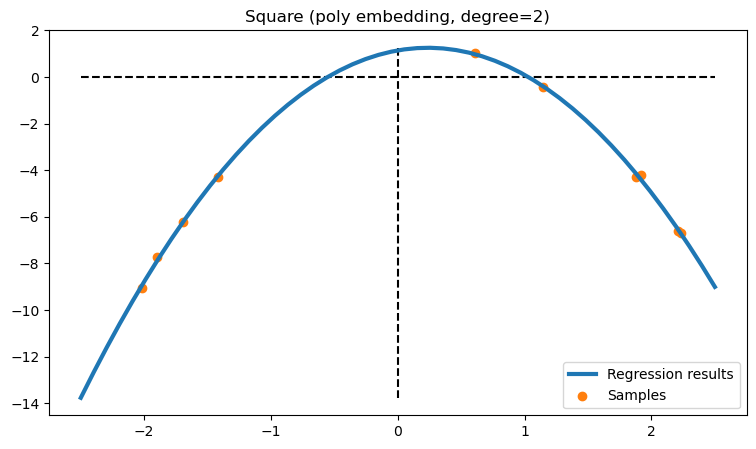

Dataset Square (poly embedding, degree=9)
Wartość funkcji kosztu: 6.79200881806637e-15


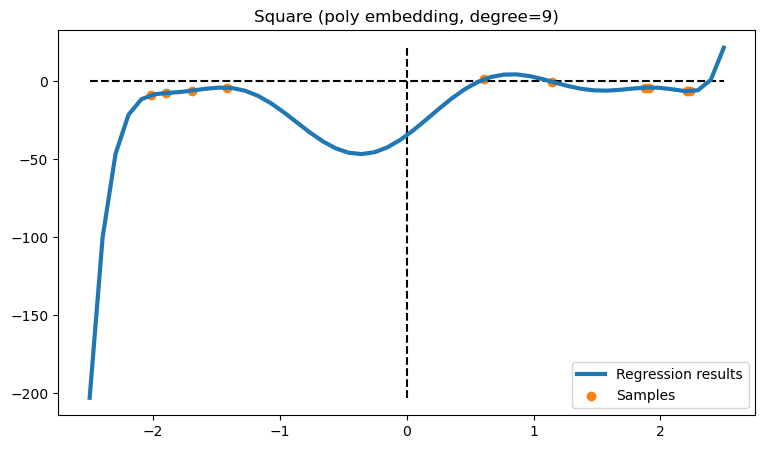

In [21]:
utils.plot_regression_results(
    square_dataset, LinearRegression, "Square (poly embedding, degree=1)", embed_poly, poly_degree=1
)
utils.plot_regression_results(
    square_dataset, LinearRegression, "Square (poly embedding, degree=2)", embed_poly, poly_degree=2
)
utils.plot_regression_results(
    square_dataset, LinearRegression, "Square (poly embedding, degree=9)", embed_poly, poly_degree=9
)

# Generalizacja
Patrząc na wykres dla zanurzenia stopnia 9 widzimy, że jest w stanie bardzo dobrze dopasować się do punktów treningowych, ale poza tymi punktami bardzo słabo aproksymuje naszą "prawdziwą" funkcję. Jest to sytuacja **overfittingu** -- model osiąga świetne wyniki na przykładach wykorzystywanych do treningu, ale dla nowych, niewidzianych wcześniej punktów będzie działał bardzo słabo.

Jakość modelu na wcześniej niewidzianych przykładach nazywamy **generalizacją** (tzn. rozwiązanie modelu generalizuje się do szerszego zbioru punktów) i to właśnie na niej zależy nam bardziej niż na jakości modelu na widzianych przykładach. Dla danych treningowych znamy już etykiety, więc model, który jest w stanie je zapamiętać niewiele nam daje. Znacznie bardziej przydatny będzie model, który dla nowych jeszcze nie widzianych danych daje sensowne estymaty.

## Jak sobie radzić z overfittingiem?

### Sposób 1: Więcej danych

Dataset Square (poly embedding)
Wartość funkcji kosztu: 0.03656955120600256


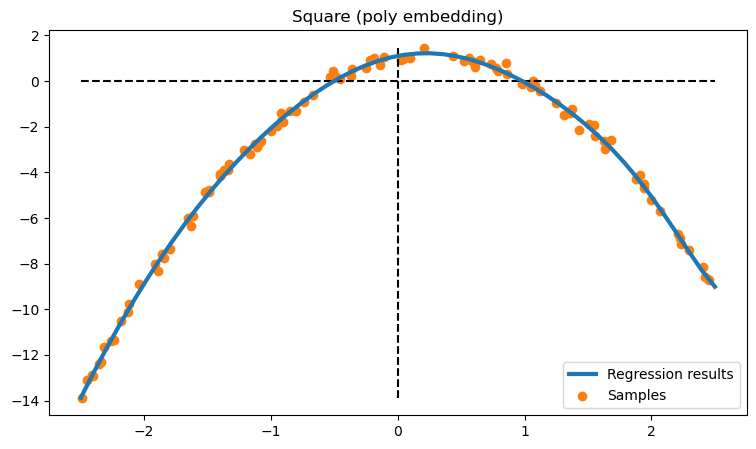

In [23]:
utils.plot_regression_results(
    bigger_square_dataset, LinearRegression, "Square (poly embedding)", embed_poly, poly_degree=9
)

### Sposób 2: Regularyzacja
Możemy też spróbować zmniejszych pojemność naszego modelu. To będziemy wykonywać w kolejnym zadaniu.

## Zadanie 2 (3 pkt.)
## Regularyzowana regresja liniowa
Czasami nie mamy wpływu na zanurzenie datasetu albo znalezienie prawidłowego zanurzenia jest bardzo trudne. Jeżeli widzimy, że nasz model overfituje do danych, możemy spróbować **regularyzacji modelu**. Zamiast zmieniać nasze dane, zmieniamy nasz model, ograniczając jego ekspresywność. W tym zadaniu należy zaimplementować regresję liniową z kosztem L2 regularyzacji wag. To oznacza, że nasza ostateczna funkcja kosztu będzie wyglądała następująco:

$$
L(X, y, w) = \frac{1}{N} \sum_{i=1}^N (w^T x_i - y_i )^2 + \alpha \|w\|^2,
$$
gdzie $\alpha$ to hiperparametr podawany przy tworzeniu funkcji.

Należy zaimplementować klasę, która będzie minimalizować powyższą funkcję za pomocą metody spadku gradientu. W szczególności trzeba zaimplementować metody:
* `fit` - dostaje na wejściu macierz przykładów `X`, wektor etykiet `y` oraz `n_steps`, czyli liczbę naturalną oznaczającą liczbę kroków w metodzie spadku gradientu. W funkcji należy zaimplementować metodę spadku gradientu, tak żeby otrzymać odpowiednie wagi.
* `predict` - dla podanej macierzy `X` podaje wektor predykcji `y`, obliczany za pomocą uzyskanych wag.
* `loss` - zwraca wartość funkcji kosztu policzonej dla podanej macierzy `X` oraz wektora etykiet `y`.



In [25]:
class RegularizedLinearRegression:
    def __init__(self, lr: float = 1e-6, alpha: float = 1e-2):
        self.learning_rate = lr
        self.alpha = alpha
        self.weight = None

    def fit(self, X: np.ndarray, y: np.ndarray, n_steps: int = int(5e4)) -> None:
        N, D = X.shape
        # Инициализируем вектор весов случайно
        self.weight = np.random.normal(size=D)
        
        for _ in range(n_steps):
            grad = self._gradient(X, y)
            # Обновляем веса: w := w - lr * grad
            self.weight = self.weight - self.learning_rate * grad

    def predict(self, X: np.ndarray) -> np.ndarray:
        return X @ self.weight

    def loss(self, X: np.ndarray, y: np.ndarray) -> float:
        N = X.shape[0]
        y_pred = self.predict(X)
        mse = np.mean((y_pred - y)**2)
        reg = self.alpha * np.sum(self.weight**2)
        return mse + reg

    def _gradient(self, X: np.ndarray, y: np.ndarray) -> np.ndarray:

        N = X.shape[0]
        y_pred = self.predict(X)
        # Вектор (Xw - y)
        diff = y_pred - y
        # Часть от MSE
        grad_mse = (2.0 / N) * (X.T @ diff)
        # Часть от регуляризации
        grad_reg = 2.0 * self.alpha * self.weight
        return grad_mse + grad_reg


In [27]:
checker.check_02_regularized_linear_regression(RegularizedLinearRegression)

Dataset Squared (poly embedding of 9, alpha=0)
Wartość funkcji kosztu: 6.79200881806637e-15


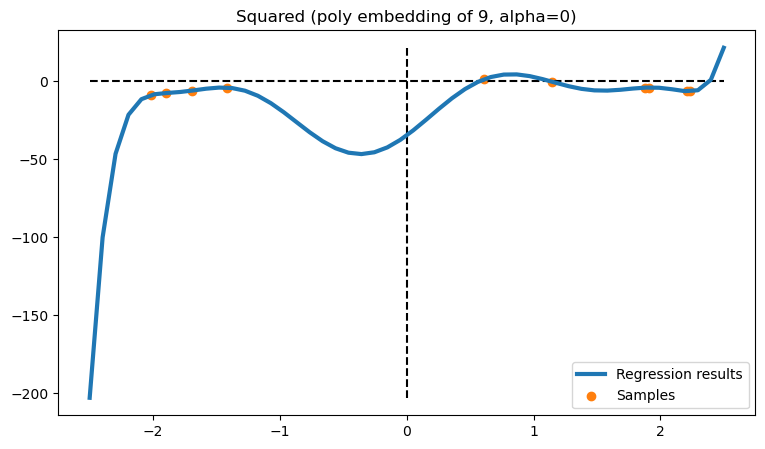

Dataset Squared (poly embedding of 9, alpha=0)
Wartość funkcji kosztu: 0.4442509943311396


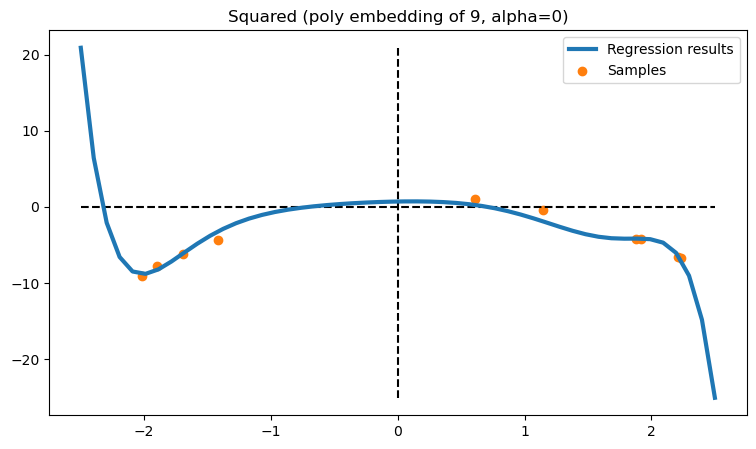

Dataset Squared (poly embedding of 9, alpha=0.01)
Wartość funkcji kosztu: 1.2628409253203177


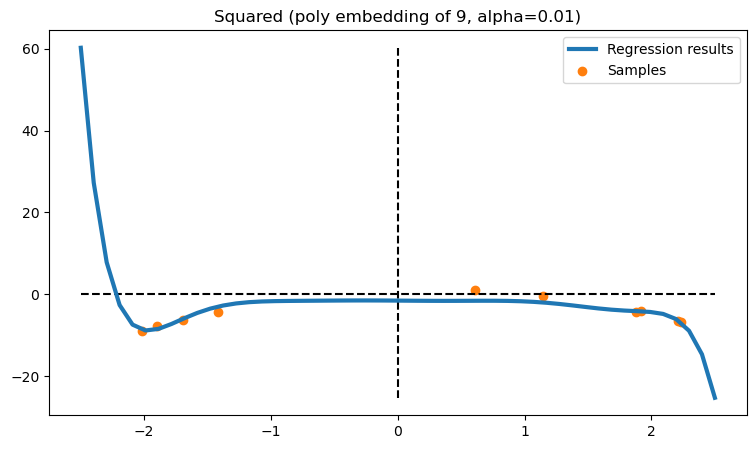

Dataset Squared (poly embedding of 9, alpha=1.0)
Wartość funkcji kosztu: 4.77996584129334


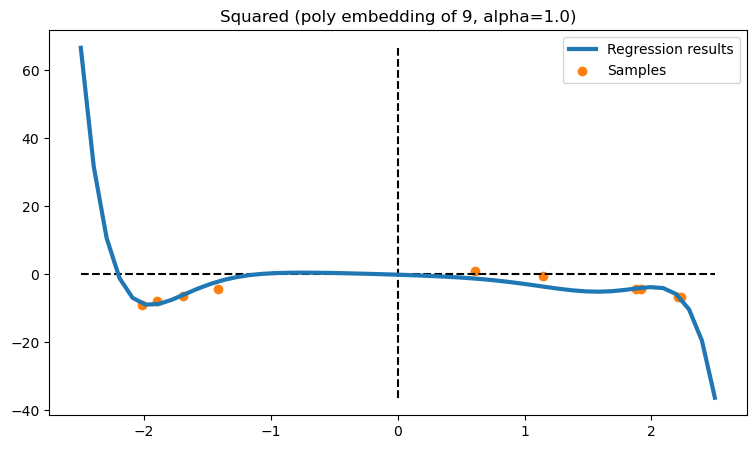

Dataset Squared (poly embedding of 9, alpha=100.0)
Wartość funkcji kosztu: 3.2321920333849583


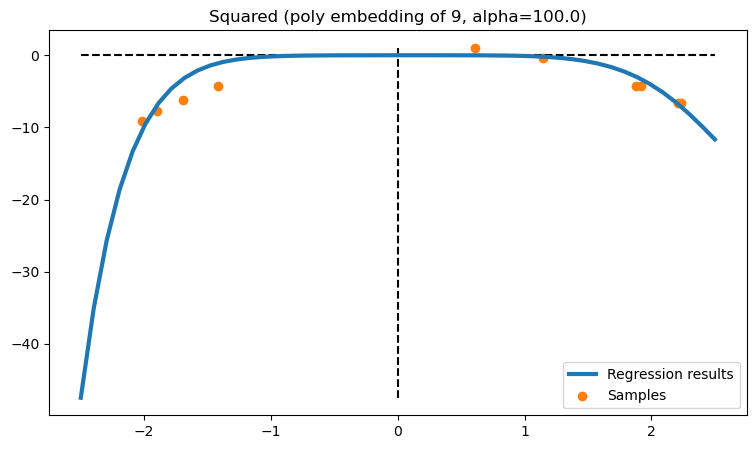

Dataset Squared (poly embedding of 9, alpha=200000)
Wartość funkcji kosztu: 25.291050905711742


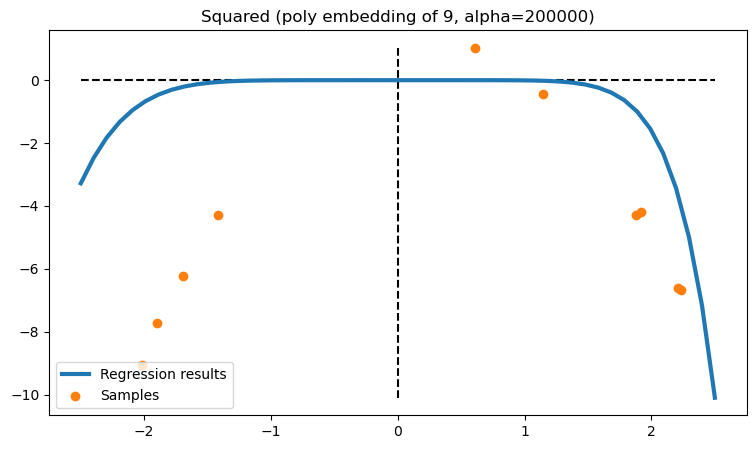

In [29]:
utils.plot_regression_results(
    square_dataset,
    LinearRegression,
    name=f"Squared (poly embedding of 9, alpha=0)",
    embed_func=embed_poly,
    poly_degree=9,
)

for alpha in [0, 1e-2, 1.0, 100.0, int(2e5)]:
    utils.plot_regression_results(
        square_dataset,
        RegularizedLinearRegression,
        regression_kwargs={"lr": 1e-6, "alpha": alpha},
        name=f"Squared (poly embedding of 9, alpha={alpha})",
        embed_func=embed_poly,
        poly_degree=9,
    )

## Zbiór treningowy i zbiór testowy

W powyższym przykładzie stwierdzaliśmy "na oko" czy funkcja, którą nasz model otrzymał jest podobna do prawdziwej funkcji, z której wygenerowano dane. W rzeczywistości nie będziemy mieli jednak bezpośredniego dostępu do funkcji generującej dane, ani nie będzie proste ocenienie "na oko" czy nasz model dobrze generalizuje.

Dlatego też wprowadzamy sobie podział zbioru danych na:
* Zbiór treningowy - na tym zbiorze poprawiamy wartości naszych parametrów i trenujemy model.
* Zbiór testowy - po wytrenowaniu modelu na zbiorze treningowym, sprawdzamy jak dobrze sobie radzi na zbiorze testowym (którego nigdy wcześniej nie widział). W efekcie zbiór testowy ma reprezentować nowe dane, które model napotka w świecie rzeczywistym.

W praktyce bardzo często chcemy dostosować w naszym modelu jakieś hiperparametry (w naszym przypadku krok uczenia oraz alfa). Najprostszym sposobem żeby dobrać hiperparametry jest po prostu sprawdzić bardzo wiele potencjalnych kombinacji. Dla każdej kombinacji (np. $\alpha = 0.04, \eta = 0.001$) uczymy model na zbiorze treningowym następnie oceniamy go **jakąś metryką**, powtarzamy dla wszystkich kombinacji i wybieramy model, który dostał najlepszy wynik według wybranej przez nas metryki.

Co do samego wyboru metryki możemy wziąć:

* Wynik na zbiorze treningowym. To kiepskie rozwiązanie, bo jak widzimy powyżej wynik na zbiorze treningowym nie zawsze jest reprezentatywny dla generalizacji (a to właśnie na generalizacji nam zależy).
* Wynik na zbiorze testowym. To jest znacznie lepsza opcja, ale jest jednak pewien haczyk. Jeżeli wykorzystamy zbiór testowy do wyboru hiperparametrów, to wynik na tym zbiorze może nie być reprezentatywny dla danych, które zobaczymy w prawdziwym świecie. Tzn. tak samo jak wcześniej overfitowaliśmy parametry do zbioru treningowego, tak samo teraz **overfitujemy hiperparametry** do zbioru testowego.


Dlatego też w praktyce wprowadza się jeszcze trzeci zbiór: zbiór walidacyjny. Wtedy:

* Dobieramy **parametry modelu** na zbiorze trenigowym (za pomocą metody spadku gradientu).
* Dobieramy **hiperparametry** na zbiorze walidacyjnym (sprawdzając różne kombinacje i wybierając najlepszą).
* Sprawdzamy wynik ostatecznego modelu na zbiorze testowym.

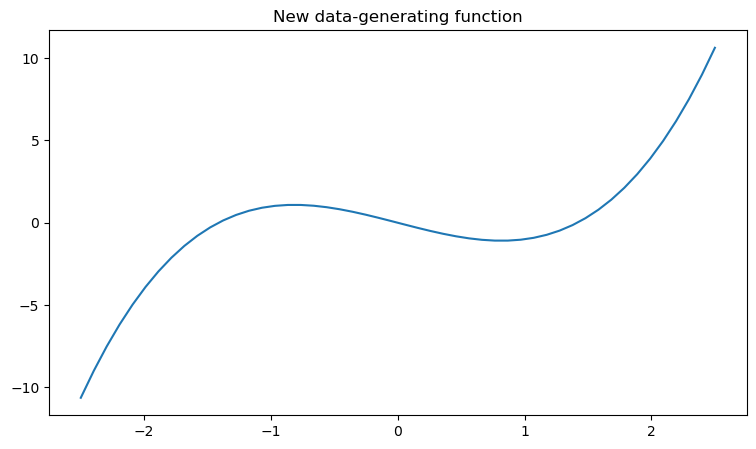

In [31]:
def cubic_func(X: np.ndarray) -> np.ndarray:
    return X**3 - 2 * X


X_linspace = np.linspace(-2.5, 2.5)
plt.plot(X_linspace, cubic_func(X_linspace))
plt.title("New data-generating function")
plt.show()

dataset = utils.create_regression_dataset(cubic_func, 500, embed_poly, {"poly_degree": 5})

## Zadanie 3 (2 pkt.)
 
Wygenerowano nowy zbiór danych z użyciem powyższej funkcji. W funkcji `split_data` otrzymasz dwie tablice `np.ndarray`: `data_x` z danymi i `data_y` z etykietami.

Zmień kolejność przykładów w otrzymanym zbiorze i podziel je w proporcjach:
* 60% na zbiór treningowy.
* 20% na zbiór walidacyjny.
* 20% na zbiór testowy.

Funkcja ma zwracać trzy obiekty: `train_set`, `valid_set`, `test_set`, z których każdy jest krotką `(dane, etykiety)`.

Następnie dobierz hiperparametry (alfa i krok uczenia) na zbiorze walidacyjnym, wytrenuj model `RegularizedLinearRegression` (z poprzedniego zadania) i sprawdź wynik na zbiorze testowym. Sprawdź w ten sposób co najmniej 10 kombinacji alfy i kroku uczenia. Zapisz wyniki poszczególnych kombinacji na zbiorze walidacyjnym i wynik ostatecznego modelu na zbiorze testowym.

Metryką służącą do wyboru modelu ma być MSE, tzn. błąd średniokwadartowy na zbiorze walidacyjnym.

In [33]:
def split_data(
    data_x: np.ndarray,
    data_y: np.ndarray,
) -> Tuple[
    Tuple[np.ndarray, np.ndarray],
    Tuple[np.ndarray, np.ndarray],
    Tuple[np.ndarray, np.ndarray]
]:
    # 1. Перемешиваем индексы
    N = data_x.shape[0]
    indices = np.arange(N)
    np.random.shuffle(indices)  # Перемешали inplace

    # 2. Считаем границы
    train_size = int(0.6 * N)
    valid_size = int(0.2 * N)
    # test_size = N - train_size - valid_size  # останется на test

    # 3. Берём по индексам
    train_idx = indices[:train_size]
    valid_idx = indices[train_size : train_size + valid_size]
    test_idx  = indices[train_size + valid_size :]

    X_train, y_train = data_x[train_idx], data_y[train_idx]
    X_valid, y_valid = data_x[valid_idx], data_y[valid_idx]
    X_test,  y_test  = data_x[test_idx],  data_y[test_idx]

    return (X_train, y_train), (X_valid, y_valid), (X_test, y_test)

train_set, valid_set, test_set = split_data(dataset.data, dataset.target)
print("Train:", train_set[0].shape, train_set[1].shape)
print("Valid:", valid_set[0].shape, valid_set[1].shape)
print("Test: ", test_set[0].shape,  test_set[1].shape)


Train: (300, 6) (300,)
Valid: (100, 6) (100,)
Test:  (100, 6) (100,)


In [38]:
# W tej komórce wykonaj przegląd hiperparametrów i wybierz najlepszy model.
train_X, train_y = train_set
valid_X, valid_y = valid_set
test_X,  test_y  = test_set

alphas = [0, 1e-5, 1e-3, 1e-2, 1e-1, 1, 10, 50, 100, 500]
lrs    = [1e-6, 1e-5, 1e-4]

best_valid_loss = float("inf")
best_params = None
best_model = None

for alpha in alphas:
    for lr in lrs:
        model = RegularizedLinearRegression(lr=lr, alpha=alpha)
        model.fit(train_X, train_y, n_steps=30000)  #30000 шагов

        # Считаем ошибку на валидации
        val_loss = model.loss(valid_X, valid_y)

        if val_loss < best_valid_loss:
            best_valid_loss = val_loss
            best_params = (alpha, lr)
            best_model = model

print(f"the best MSE + reg = {best_valid_loss:.6f} при alpha={best_params[0]}, lr={best_params[1]}")

# Оцениваем на тестовых данных
test_loss = best_model.loss(test_X, test_y)
print(f"Loss (MSE + reg): {test_loss:.6f}")


the best MSE + reg = 0.039385 при alpha=0, lr=0.0001
Loss (MSE + reg): 0.045139


### Dygresje
* MSE jako funkcja kosztu w regresji liniowej można wyprowadzić z perspektywy rachunku prawdopodobieństwa. Jeśli przyjmiejmy, że do naszych etykiet został dodany szum z rozkładu Gaussowskiego o średniej 0, a następnie będziemy skorzystamy z Maximum Likelihood Estimation, to dojdziemy do dobrego wyniku. [Więcej tutaj](https://stats.stackexchange.com/a/265430).

* Regularyzacja będzie pojawiać się później bardzo często w kontekście sieci neuronowych -- nakładanie kar na normę wag to tylko najprostsza z możliwych metod.